In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Paths
base_dir = '/content/drive/MyDrive/***DataSet_Thesis2024/new2024_orgImg'  # Replace with your dataset folder in Google Drive
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
model_save_path = '/content/drive/MyDrive/***DataSet_Thesis2024/new2024_1/modeloutput/efficentnetB7/30_R1_OrgImage_efficientnetb7_clean_vs_unclean.pth'  # Replace with desired save path

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_CLASSES = 2
EPOCHS = 30
LEARNING_RATE = 0.001
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
DEVICE

'cuda'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 196MB/s]


Epoch 1/30
--------------------
Train Loss: 0.1772 Acc: 0.9444
Val Loss: 0.0451 Acc: 0.9850
Epoch 2/30
--------------------
Train Loss: 0.0731 Acc: 0.9806
Val Loss: 0.0157 Acc: 0.9956
Epoch 3/30
--------------------
Train Loss: 0.0728 Acc: 0.9775
Val Loss: 0.5409 Acc: 0.8431
Epoch 4/30
--------------------
Train Loss: 0.0224 Acc: 0.9931
Val Loss: 0.0263 Acc: 0.9919
Epoch 5/30
--------------------
Train Loss: 0.0427 Acc: 0.9850
Val Loss: 0.0292 Acc: 0.9906
Epoch 6/30
--------------------
Train Loss: 0.0145 Acc: 0.9938
Val Loss: 0.0300 Acc: 0.9919
Epoch 7/30
--------------------
Train Loss: 0.0424 Acc: 0.9875
Val Loss: 0.0297 Acc: 0.9925
Epoch 8/30
--------------------
Train Loss: 0.0242 Acc: 0.9919
Val Loss: 0.0677 Acc: 0.9894
Epoch 9/30
--------------------
Train Loss: 0.0048 Acc: 0.9975
Val Loss: 0.0850 Acc: 0.9850
Epoch 10/30
--------------------
Train Loss: 0.0317 Acc: 0.9906
Val Loss: 0.0226 Acc: 0.9900
Epoch 11/30
--------------------
Train Loss: 0.0055 Acc: 0.9981
Val Loss: 0.000

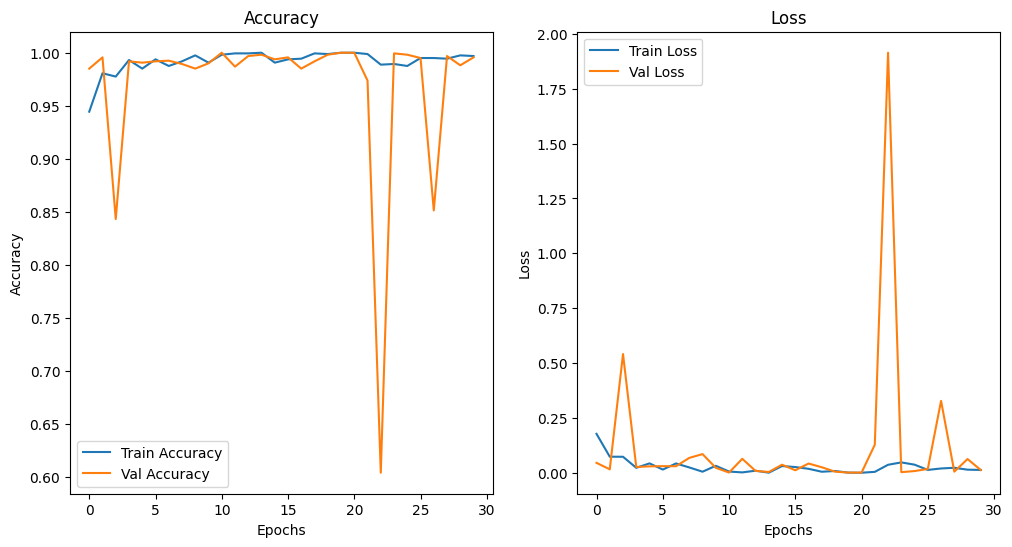

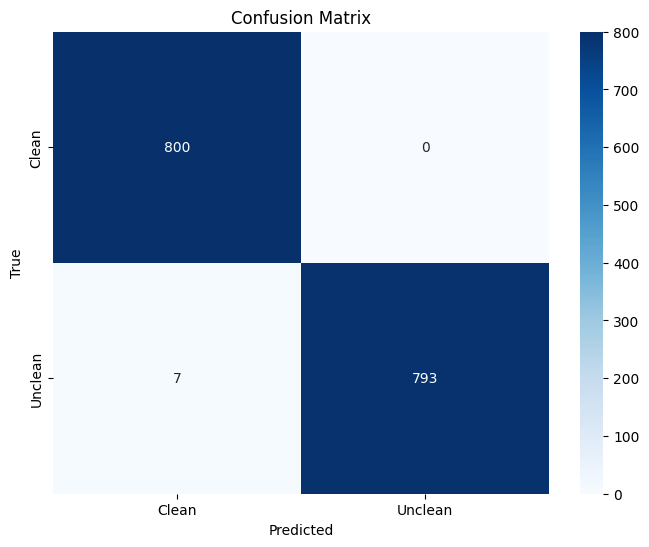

Classification Report:

              precision    recall  f1-score   support

       Clean   0.991326  1.000000  0.995644       800
     Unclean   1.000000  0.991250  0.995606       800

    accuracy                       0.995625      1600
   macro avg   0.995663  0.995625  0.995625      1600
weighted avg   0.995663  0.995625  0.995625      1600

Model saved successfully to /content/drive/MyDrive/***DataSet_Thesis2024/new2024_1/modeloutput/efficentnetB7/30_R1_OrgImage_efficientnetb7_clean_vs_unclean.pth


In [5]:
# Data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Datasets and DataLoaders
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model: EfficientNetB7
model = models.efficientnet_b7(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Linear(128, NUM_CLASSES)
)
model = model.to(DEVICE)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 20)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        history['val_loss'].append(epoch_loss)
        history['val_acc'].append(epoch_acc.item())

        print(f"Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Save the best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model, history

# Train the model
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS)

# Plot accuracy and loss graphs
def plot_history(history):
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

# Evaluate the model on the validation set
model.eval()
all_preds = []
all_labels = []
for inputs, labels in val_loader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes,digits=6))

# Save the model
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
torch.save(model.state_dict(), model_save_path)
print(f"Model saved successfully to {model_save_path}")
